## Introduction to Python for Hydrology
## Session 5: Aggregating Daily Data to Month, Irrigation Season, Annual

Prepared by Brad Wolaver<br>
New Mexico Office of the State Engineer, Hydrology Bureau, Santa Fe, NM<br>
November 14, 2024 (Updated January 3, 2025)

## Objective
Learn to aggregate daily data to monthly, irrigation season, and annual summaries.

## Expected Outcomes
By the end of this session, you should be able to:
- Run a python script in Jupyter Notebook
- Convert streamflow data from cubic feet per second to:
    - Monthly (acre-feet)
    - Irrigation Season (acre-feet)
    - Year (acre-feet)
- Make boxplot of monthly streamflow
- Plot annual streamflow

## Step 0. Activate Environment in Anaconda Prompt Before Running this Jupyter Notebook

#### In Anaconda Prompt, make sure you have updated the python_hydro environment using environment_update.yml
#### If you haven't done this yet, see Sessions 3 and 4 for instructions.
#### Open Anaconda Prompt and change your working directory with `cd <path to working directory>`
#### Activate environment with `conda activate python_hydro`

## Step 1. Install Necessary Libraries

In [1]:
# Importing necessary libraries for downloading and manipulating USGS gage data

# Data Download
import hydrofunctions as hf  # hydrofunctions is used to download USGS gage data from the web

# Data Manipulation
import pandas as pd  # pandas is used for data manipulation and analysis
from datetime import date, timedelta  # datetime is used to work with dates

# Plotting
import matplotlib.pyplot as plt  # matplotlib is a library for plotting data
import matplotlib.dates as mdates # mdates is a module for handling date and time data in plots
from matplotlib.ticker import FuncFormatter # used to add commas to separate thousands in y-axis labels for streamflow (ex: 10,000 not 10000)
import matplotlib.gridspec as gridspec # makes grid lines for plots
import seaborn as sns # for boxplots

# Data Manipulation for Plotting: Used in plotting to dentify continuous periods of missing data and then annotate each period
import numpy as np
from itertools import groupby
from operator import itemgetter

# Note: %matplotlib inline is a "magic command" and neets to have its own line to work correctly; you can't put a # COMMENT after '%matplotlib inline'
%matplotlib inline

## Step 2. Run Code from Session 4 to Prepare the DataFrame You'll Work With Today

`%run` is a magic command in Jupyter Notebook that allows you to run an external Python script (.py file) as if it were executed within the notebook. This command imports all variables, functions, and classes from the script, making them directly accessible in the notebook environment.

`%run` is useful additional because it executes the script and also integrates its contents into the notebook’s workspace.

We are using `%run` to download the data from Session 4 using hydrofunctions.

Before you use `%run`, make sure the file `session5_setup_df2_final.py` is in the same folder as the Session 5 jupyter notebook.

Start date is set to: 1889-01-01
End date is set to: 2025-01-07
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08279500%2C08313000&parameterCd=00060&startDT=1889-01-01&endDT=2025-01-07

Data download status: True
'True' indicates download successful

USGS:08279500: RIO GRANDE AT EMBUDO, NM
    00060: <Day>  Discharge, cubic feet per second 
USGS:08313000: RIO GRANDE AT OTOWI BRIDGE, NM
    00060: <Day>  Discharge, cubic feet per second 
Start: 1889-01-01 00:00:00+00:00
End:   2025-01-07 00:00:00+00:00

The head of the DataFrame is:

                           Embudo_cfs Embudo_qual  Otowi_cfs    Otowi_qual
datetimeUTC                                                               
1889-01-01 00:00:00+00:00       398.0           A        NaN  hf.upsampled
1889-01-02 00:00:00+00:00       385.0           A        NaN  hf.upsampled
1889-01-03 00:00:00+00:00       395.0           A        NaN  hf.upsampled
1889-01-04 00:00:00+00:00       400.0           A

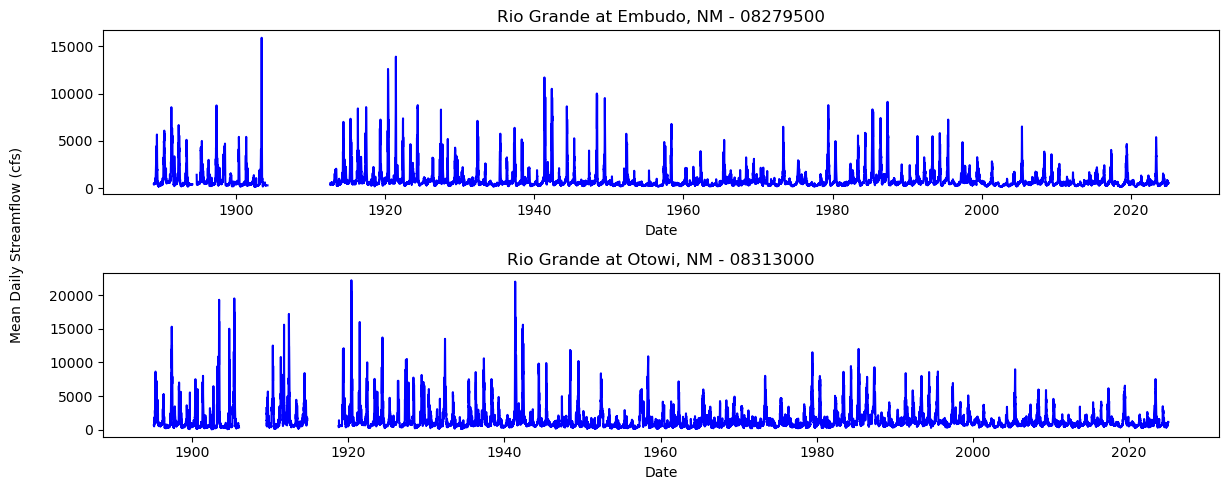

<Figure size 640x480 with 0 Axes>

In [2]:
# Run the setup file to create DataFrame df2
%run ./session5_setup_df2_final.py

Take a look at DataFrame `df2`, which was created from downloaded streamflow data.

In [3]:
# Export dataframe to a csv if you want (makes it easy to see what's in the dataframe)
df2.to_csv('df2_cfs.csv', index=True, date_format='%Y-%m-%d')

## Step 3. Dealing with Missing Data

**Creating Binary Availability Indicators for Streamflow Data**

To better understand data coverage for each USGS streamgage, we will create new columns to flag missing streamflow values, incorporating the unique data quality codes (`_qual`) that indicate certain types of missing or interpolated data.

1. **Otowi_cfs_available**: This column will be `True` if the daily mean streamflow value (`Otowi_cfs`) is available, and `False` if it is missing.
2. **Embudo_cfs_available**: This column will similarly flag availability for the `Embudo_cfs` values.

These indicators will help us quickly identify periods with gaps in the dataset, making them useful for later aggregation and trend analysis.

**Handling Special Missing Data Flags**
Some specific data quality codes indicate missing data:

- **`hf.missing`**: Flags readings that are entirely missing from the dataset.
- **`hf.upsampled`**: Flags interpolated readings inserted to fill gaps between observed data points.

These codes, found in the `_qual` columns for each gage, will be treated as missing data. Therefore, any day flagged as `hf.missing` or `hf.upsampled` will be marked as `False` in the availability columns, even if a numerical streamflow value is present.

Before making these additions, we will create a copy of our DataFrame (`df3`) to keep the original data (`df2`) unchanged. This section demonstrates how to use pandas to check for missing values and populate a column with logical (True/False) values based on data availability.


**Explanation**

For both columns (`Otowi_cfs` and `Embudo_cfs`), this code creates a new binary column (`_available`) that indicates whether data is available (i.e., not missing or flagged as interpolated) for each row. The column will be `True` if data is valid and `False` if the data is missing or flagged as missing.

**Details**

Using the Otowi gage as an example (the logic is the same for Embudo):

- `df3['Otowi_cfs'].notna()`: This checks if the `Otowi_cfs` value is not missing (i.e., not `NaN`). It returns `True` if the value is available (not `NaN`) and `False` if it's missing.

- `df3['Otowi_qual'].isin(missing_codes)`: This checks if the value in the `Otowi_qual` column is one of the codes that indicate missing or interpolated data (i.e., `hf.missing` or `hf.upsampled`). It returns `True` if the quality code matches any of the missing codes and `False` otherwise.

- `~` (tilde): This negates the condition. So, `~df3['Otowi_qual'].isin(missing_codes)` will return True when the quality code is not hf.missing or hf.upsampled.

- `&` (and operator): This ensures that both conditions must be `True` for the new column to be `True`. The availability indicator will be `True` if the streamflow value is available (not `NaN`) and the quality code is not a missing or interpolated code.

In [4]:
# Make a copy of df2 to retain the original DataFrame as df2 and work on a new DataFrame called df3
df3 = df2.copy()

# Define a list of codes that indicate missing data based on the _qual column descriptions
missing_codes = ['hf.missing', 'hf.upsampled']

# Create a binary availability indicator for each streamflow column, considering _qual codes

# 1. For 'Otowi_cfs': True if data is available and not flagged as missing, False if missing or flagged as missing.
df3['Otowi_cfs_available'] = df3['Otowi_cfs'].notna() & ~df3['Otowi_qual'].isin(missing_codes)

# 2. For 'Embudo_cfs': Same logic as above, checking for missing or flagged-as-missing entries.
df3['Embudo_cfs_available'] = df3['Embudo_cfs'].notna() & ~df3['Embudo_qual'].isin(missing_codes)

# Display the first few rows of df3 to verify the changes
df3.head()

,Embudo_cfs,Embudo_qual,Otowi_cfs,Otowi_qual,Otowi_cfs_available,Embudo_cfs_available
datetimeUTC,,,,,,
1889-01-01 00:00:00+00:00,398.0,A,NaN,hf.upsampled,False,True
1889-01-02 00:00:00+00:00,385.0,A,NaN,hf.upsampled,False,True
1889-01-03 00:00:00+00:00,395.0,A,NaN,hf.upsampled,False,True
1889-01-04 00:00:00+00:00,400.0,A,NaN,hf.upsampled,False,True
1889-01-05 00:00:00+00:00,413.0,A,NaN,hf.upsampled,False,True


Explore the Data:

In [5]:
# Count True/False values for Otowi_cfs_available
otowi_counts = df3['Otowi_cfs_available'].value_counts()

# Count True/False values for Embudo_cfs_available
embudo_counts = df3['Embudo_cfs_available'].value_counts()

print(f"Otowi_cfs_available counts:")
print(otowi_counts)

print("\nEmbudo_cfs_available counts:")
print(embudo_counts)

Otowi_cfs_available counts:
Otowi_cfs_available
True     44719
False     4961
Name: count, dtype: int64

Embudo_cfs_available counts:
Embudo_cfs_available
True     46381
False     3299
Name: count, dtype: int64


#### Visualize Where Missing Data Occur

Display missing data points on the hydrograph with red, semi-transparent vertical lines.

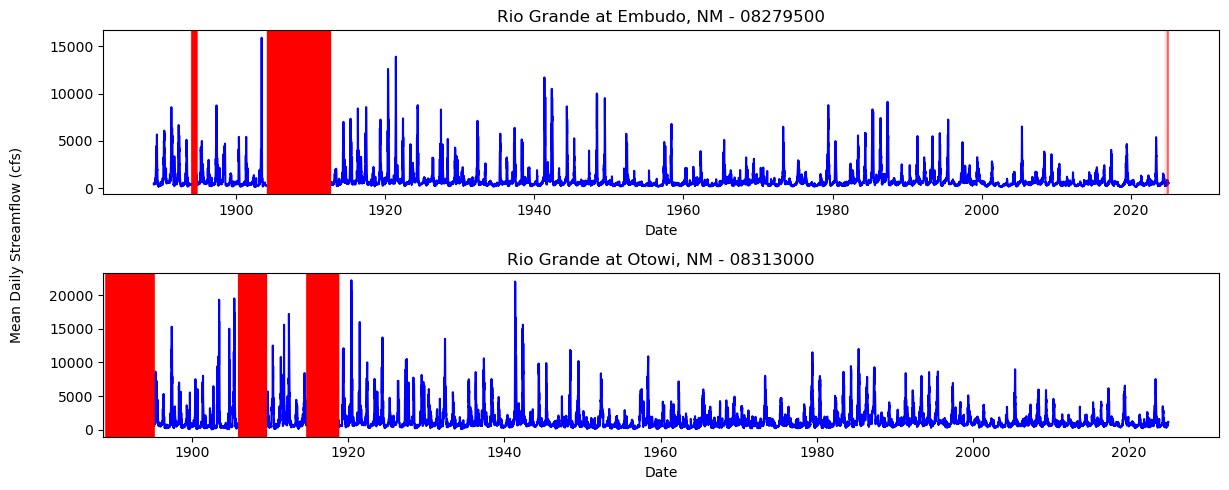

In [6]:
# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 5))

# Top subplot: Embudo Streamflow
ax[0].plot(df2.index, df2['Embudo_cfs'], label='Embudo Streamflow (cfs)', color='blue')
ax[0].set_title('Rio Grande at Embudo, NM - 08279500')
ax[0].set_xlabel('Date')

# Add vertical red lines for missing data in Embudo streamflow
missing_dates_embudo = df3[df3['Embudo_cfs_available'] == False].index
for date in missing_dates_embudo:
    ax[0].axvline(x=date, color='red', alpha=0.1)

# Bottom subplot: Otowi Streamflow
ax[1].plot(df2.index, df2['Otowi_cfs'], label='Otowi Streamflow (cfs)', color='blue')
ax[1].set_title('Rio Grande at Otowi, NM - 08313000')
ax[1].set_xlabel('Date')

# Add vertical red lines for missing data in Otowi streamflow
missing_dates_otowi = df3[df3['Otowi_cfs_available'] == False].index
for date in missing_dates_otowi:
    ax[1].axvline(x=date, color='red', alpha=0.1)

# Common y-axis label
fig.text(-0.02, 0.5, 'Mean Daily Streamflow (cfs)', va='center', rotation='vertical')

# Adjust layout and display the plot
plt.tight_layout()

**Explanation**

- Identify missing data by checking where `Embudo_cfs_available` or `Otowi_cfs_available` is `Fals`e in the `df3` DataFrame.
- The `axvline()` function is used to plot vertical red lines at these missing data points.
- The `alpha=0.5` parameter makes the vertical lines semi-transparent, so the underlying data remains visible.


#### Improve Visualization of Missing Data

**A few improvements:**
1. Add legends to each subplot and place them in the top right of each subplot.
2. Make missing data more visually appealing by replacing vertical red lines (which do not show transparency well) with red, transparent patches.
3. Add labels, called annotations, to the missing data periods to show number of days of missing data.
4. Use a comma for 1,000's in y-axis tick labels.
5. Add a buffer to stop looking for missing data 100 days before the end of record.  Why? Because we will not use year 2024 because it's not complete.

**How did I do this:**<br>
My approach was to:
1. Take the script from Session 4 (that is also included in `session5_setup_df2.py`) that we used to create the two-panel hydrograph.
2. Paste the script into an AI tool and prompt it to add red lines for missing data and to make them a transparency.
3. When I could not make the hundreds of adjacent red lines appear transparent, I prompted the AI tool to try a different approach and group all the adjacent missing-data days into one element and make these elements transparent.  That worked.
4. Then I made a series of modifications to the code by prompting AI with each change, one by one, until I got what I wanted.  It's a bit of an iterative approach.

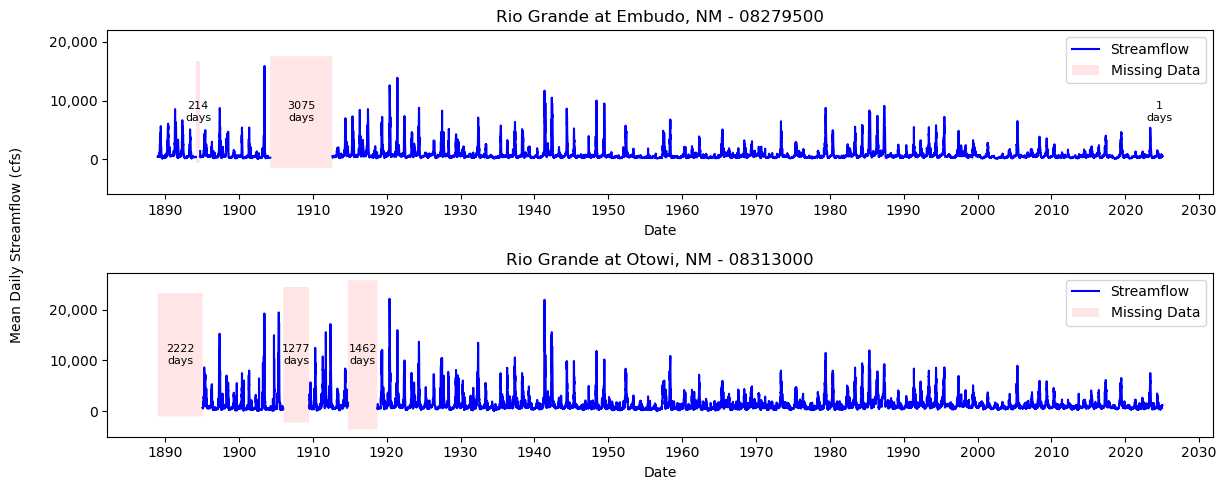

In [7]:
# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 5))

# Function to format y-axis labels with commas
def format_with_commas(x, p):
    return f"{x:,.0f}"

# Function to find continuous periods of missing data
def find_missing_periods(data):
    missing = np.where(~data)[0]
    periods = []
    for k, g in groupby(enumerate(missing), lambda ix: ix[0] - ix[1]):
        group = list(map(itemgetter(1), g))
        periods.append((group[0], group[-1]))
    return periods

# Top subplot: Embudo Streamflow
ax[0].plot(df2.index, df2['Embudo_cfs'], label='Embudo Streamflow (cfs)', color='blue')
ax[0].set_title('Rio Grande at Embudo, NM - 08279500')
ax[0].set_xlabel('Date')
ax[0].yaxis.set_major_formatter(FuncFormatter(format_with_commas))

# For Embudo streamflow
missing_periods_embudo = find_missing_periods(df3['Embudo_cfs_available'])

# Add red areas for missing data in Embudo streamflow and annotate
for start, end in missing_periods_embudo:
    missing_days = end - start + 1
    mid_point = df3.index[start + (end - start) // 2]
    y_min, y_max = ax[0].get_ylim()
    ax[0].fill_between(df3.index[start:end+1], y_min, y_max, 
                       facecolor='red', alpha=0.1)
    # Only annotate if the end of the missing period is more than 10 days from the end of the record
    if (df3.index[-1] - df3.index[end]).days > 100:
        ax[0].annotate(f'{missing_days}\ndays', (mid_point, (y_min + y_max) / 2),
                       xytext=(0, 0), textcoords='offset points',
                       ha='center', va='center', fontsize=8)

# Add legend to top right of top subplot
ax[0].legend(['Streamflow', 'Missing Data'], loc='upper right')

# Bottom subplot: Otowi Streamflow
ax[1].plot(df2.index, df2['Otowi_cfs'], label='Otowi Streamflow (cfs)', color='blue')
ax[1].set_title('Rio Grande at Otowi, NM - 08313000')
ax[1].set_xlabel('Date')
ax[1].yaxis.set_major_formatter(FuncFormatter(format_with_commas))

# For Otowi streamflow
missing_periods_otowi = find_missing_periods(df3['Otowi_cfs_available'])

# Add red areas for missing data in Otowi streamflow and annotate
for start, end in missing_periods_otowi:
    missing_days = end - start + 1
    mid_point = df3.index[start + (end - start) // 2]
    y_min, y_max = ax[1].get_ylim()
    ax[1].fill_between(df3.index[start:end+1], y_min, y_max, 
                       facecolor='red', alpha=0.1)
    # Only annotate if the end of the missing period is more than 10 days from the end of the record
    if (df3.index[-1] - df3.index[end]).days > 100:
        ax[1].annotate(f'{missing_days}\ndays', (mid_point, (y_min + y_max) / 2),
                       xytext=(0, 0), textcoords='offset points',
                       ha='center', va='center', fontsize=8)

# Common y-axis label
fig.text(-0.02, 0.5, 'Mean Daily Streamflow (cfs)', va='center', rotation='vertical')

# Add legend to top right of bottom subplot
ax[1].legend(['Streamflow', 'Missing Data'], loc='upper right')

# Improve x-axis date formatting
for axis in ax:
    # Set major ticks to years
    axis.xaxis.set_major_locator(mdates.YearLocator(10))
    
    # Format the date
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Rotate and align the tick labels so they look better
    for label in axis.get_xticklabels():
        label.set_rotation(0)
        label.set_horizontalalignment('center')

# Adjust the subplot layout
plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('hydrograph_2panel_with_missing_data.png', format='png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

#### Explanation of Code: Two-Panel Hydrograph Plot with Missing Data Annotation

**Explanation:** 

- This script generates a two-panel hydrograph plot displaying streamflow data for the Rio Grande at two USGS gage locations: Embudo and Otowi in New Mexico.
- It highlights missing data periods with red shading and annotations indicating the duration of each missing period.

1. **Libraries Used**:
    - **hydrofunctions**: Used to download streamflow data from the USGS, enabling easy access to specific gage locations.
    - **pandas**: Manages data organization and manipulation, specifically for time series data.
    - **datetime**: Handles date operations to manage and format time-related data.
    - **matplotlib.pyplot**: Provides plotting functions to create visualizations such as line plots for streamflow data.
    - **matplotlib.dates (mdates)**: Formats date-related information on the x-axis.
    - **FuncFormatter**: Part of `matplotlib.ticker`, used here to format y-axis labels with commas for readability.
    - **numpy (np)**: Identifies missing data points, aiding in the annotation of data gaps.
    - **itertools.groupby and operator.itemgetter**: Groups consecutive missing data points for annotating continuous gaps.

2. **Code Structure**:
    - `fig, ax = plt.subplots(2, 1, figsize=(12, 5))`: Creates two stacked subplots in a single figure, one for each stream gage location.

3. **Custom Functions**:
    - `format_with_commas(x, p)`: Formats large y-axis values with commas to improve readability.
    - `find_missing_periods(data)`: Locates continuous periods of missing data by:
        - Identifying missing values' indices.
        - Grouping these indices into continuous ranges.
        - Storing each range’s start and end for plotting.

4. **Top Subplot (Embudo Streamflow)**:
    - `ax[0].plot(...)`: Plots Embudo streamflow data on the first subplot in blue, with labels and axis formatting.
    - `missing_periods_embudo = find_missing_periods(...)`: Finds missing data periods for Embudo, enabling annotations.
    - Loop over missing periods:
        - `fill_between(...)`: Shades missing periods with red.
        - `annotate(...)`: Adds annotations showing the length of each missing period.

5. **Bottom Subplot (Otowi Streamflow)**:
    - Similar to the top subplot, with streamflow data for Otowi.
    - Missing data periods are highlighted with shading and annotated with their durations.

6. **Common Y-Axis Label and Legends**:
    - `fig.text(...)`: Adds a central y-axis label for both subplots: "Mean Daily Streamflow (cfs)".
    - `legend(...)`: Legends are added to both subplots, indicating "Streamflow" and "Missing Data" for clarity.

7. **X-Axis Date Formatting**:
    - Loop for x-axis formatting:
        - `YearLocator` and `DateFormatter`: Sets major ticks at 10-year intervals and formats tick labels as four-digit years.
        - Adjusts tick label alignment and rotation for readability.

8. **Final Layout Adjustments**:
    - `plt.tight_layout()`: Ensures proper spacing and alignment of subplots and labels.
    - `plt.savefig(...)`: Saves the plot as a high-resolution PNG file.
    - `plt.show()`: Displays the plot within the notebook.

This code provides a visual analysis of streamflow at two locations and highlights data gaps for a clearer understanding of the record completeness.


## Step 4. Find the Earliest Day in Common with Non-Missing Data

**Why?**<br>
When conducting time series analyses on multiple datasets, such as the Embudo and Otowi gages, it's generally best practice to align the datasets to a common time frame. This approach ensures that both series cover the same period, allowing for meaningful comparisons and analyses.<br><br>
**Reasons for Aligning Time Series:**

- **Consistency**: Aligning the datasets ensures that both series have data points for the same time intervals, preventing discrepancies that could arise from comparing data with different time spans.

- **Comparative Analysis**: Many time series analyses, including change point detection and statistical modeling, rely on the assumption that the datasets being compared are synchronized. Misaligned data can lead to misleading conclusions.

- **Data Integrity**: Aligning the datasets helps in identifying and handling missing data consistently across both series, ensuring that any gaps are addressed appropriately.

**How to Align the Datasets:**

1. **Identify the Common Time Frame**: Determine the earliest date when both datasets have valid (non-NaN) entries. This can be done by finding the maximum of the earliest valid dates from both series.

2. **Subset the Data**: Filter both datasets to include only the data from this common time frame onward.

3. **Handle Any Missing Data**: Decide on a strategy for dealing with missing data, such as interpolation, forward filling, or excluding missing values, ensuring consistency across both series.

By aligning the Embudo and Otowi gage data to a common time frame, you establish a solid foundation for subsequent analyses, leading to more reliable and interpretable results.

#### First, what variables and DataFrames are in memory?

In a Jupyter Notebook or a Python script, when you execute code, variables are stored in a namespace, and Python keeps track of these namespaces to determine where to look for a specific variable or function. This helps prevent naming conflicts (e.g., a local variable `x` inside a function doesn’t overwrite a global variable `x`).  The following command lists the names of all the variables (including dataframes) in the current memory.

In [8]:
%who

FuncFormatter	 ax	 axis	 data	 date	 df	 df2	 df3	 embudo_counts	 
end	 end_date	 fig	 find_missing_periods	 format_with_commas	 gridspec	 groupby	 hf	 itemgetter	 
label	 mdates	 mid_point	 missing_codes	 missing_dates_embudo	 missing_dates_otowi	 missing_days	 missing_periods_embudo	 missing_periods_otowi	 
np	 otowi_counts	 pcode	 pd	 plt	 sites	 sns	 start	 start_date	 
timedelta	 today	 y_max	 y_min	 yesterday	 


<br>If you specifically want to filter and see only the dataframes, you can use a more specific approach:

In [9]:
%who DataFrame

# del df3

df	 df2	 df3	 


In [10]:
print(list(df3.columns))

['Embudo_cfs', 'Embudo_qual', 'Otowi_cfs', 'Otowi_qual', 'Otowi_cfs_available', 'Embudo_cfs_available']


#### Identify the Common Time Frame
Determine the earliest date when both datasets have valid (non-NaN) entries. 

In [11]:
# Find the first valid index for 'Embudo_cfs' and 'Otowi_cfs'
first_valid_embudo = df3['Embudo_cfs'].first_valid_index()
first_valid_otowi = df3['Otowi_cfs'].first_valid_index()

# Determine the latest of these two dates
earliest_common_date = max(first_valid_embudo, first_valid_otowi)

print(f"The earliest common date with non-NaN values in both 'Embudo_cfs' and 'Otowi_cfs' is: {earliest_common_date}")

The earliest common date with non-NaN values in both 'Embudo_cfs' and 'Otowi_cfs' is: 1895-02-01 00:00:00+00:00


But this doesn't quite do what we want.  Let's adjust the code to find the start of continuous data.  We do this, by setting a threshold of 100 days, which assumes that 100 consecutive True values in both_available will be considered sufficient for continuous data.

#### Find the Start of Continuous Data

But this doesn’t quite do what we want. Let’s adjust the code to find the start of continuous data. We do this, by setting a threshold of 100 days, which assumes that 100 consecutive True values in `both_available` will be considered sufficient for continuous data.

In [12]:
# Assuming df3 is your DataFrame
# Ensure the index is a datetime index
df3.index = pd.to_datetime(df3.index)

# Function to find the start of continuous data
# A threshold of 100 days  assumes that 100 consecutive True values in both_available is sufficient for continuous data
def find_continuous_data_start(df, threshold=100):
    # Create a series that's True when both datasets are available
    both_available = df['Otowi_cfs_available'] & df['Embudo_cfs_available']
    
    # Find the runs of True values
    runs = both_available.ne(both_available.shift()).cumsum()
    
    # Count the length of each run
    run_lengths = runs.groupby(runs).count()
    
    # Find runs that are longer than the threshold
    long_runs = run_lengths[run_lengths >= threshold]
    
    if not long_runs.empty:
        # Find the start of the longest run
        longest_run_start = long_runs.idxmax()
        return df.index[runs == longest_run_start].min()
    else:
        return df.index[0]  # If no long runs, return the earliest date

# Find the start of continuous data
continuous_start = find_continuous_data_start(df3)

print(f"The earliest date with continuous data for both Embudo and Otowi is: {continuous_start}")

# Display the data for this date
print("\nData for the earliest continuous date:")
print(df3.loc[continuous_start])

# Optional: Display some statistics
print(f"\nTotal number of records: {len(df3)}")
print(f"Date range of the dataset: {df3.index.min()} to {df3.index.max()}")
print(f"Number of days with continuous data: {(df3.index.max() - continuous_start).days}")

The earliest date with continuous data for both Embudo and Otowi is: 1918-10-01 00:00:00+00:00

Data for the earliest continuous date:
Embudo_cfs              481.0
Embudo_qual                 A
Otowi_cfs               530.0
Otowi_qual                  A
Otowi_cfs_available      True
Embudo_cfs_available     True
Name: 1918-10-01 00:00:00+00:00, dtype: object

Total number of records: 49680
Date range of the dataset: 1889-01-01 00:00:00+00:00 to 2025-01-07 00:00:00+00:00
Number of days with continuous data: 38815


#### Filter the DataFrame by the earliest date with continuous data for both Embudo and Otowi

We'll do this by using the variable `continuous_start`, which stores the result returned by the function find_continuous_data_start(df3).  This is the earliest date in df3 where both `Otowi_cfs_available` and `Embudo_cfs_available` columns have continuous data for at least 100 consecutive days (or as specified by the threshold parameter).

In [13]:
# Create df4 by filtering df3 from the continuous start date
df4 = df3.loc[continuous_start:]

print(f"The earliest date with continuous data for both Embudo and Otowi is: {continuous_start}")

# .shape is an attribute (not a method, so it doesn’t need parentheses) that provides the dimensions of the DataFrame df4 as a tuple.
# When you call df4.shape, it returns:
# df4.shape[0]: The number of rows in df4.
# df4.shape[1]: The number of columns in df4.
# For example, if df4 has 100 rows and 5 columns, df4.shape would return (100, 5).

print(f"\nShape of df4: {df4.shape}")
print("\nFirst few rows of df4:")
print(df4.head())

The earliest date with continuous data for both Embudo and Otowi is: 1918-10-01 00:00:00+00:00

Shape of df4: (38816, 6)

First few rows of df4:
                           Embudo_cfs Embudo_qual  Otowi_cfs Otowi_qual  \
datetimeUTC                                                               
1918-10-01 00:00:00+00:00       481.0           A      530.0          A   
1918-10-02 00:00:00+00:00       454.0           A      510.0          A   
1918-10-03 00:00:00+00:00       428.0           A      490.0          A   
1918-10-04 00:00:00+00:00       416.0           A      450.0          A   
1918-10-05 00:00:00+00:00       395.0           A      435.0          A   

                           Otowi_cfs_available  Embudo_cfs_available  
datetimeUTC                                                           
1918-10-01 00:00:00+00:00                 True                  True  
1918-10-02 00:00:00+00:00                 True                  True  
1918-10-03 00:00:00+00:00                 Tru

#### Check DataFrame df4

I like to do this to learn about the DataFrame.

In [14]:
# Get dataframe index name
print('The dataframe index name is:\n', df4.index.name)

# Get dataframe keys
# Get the keys of the dataframe
keys = df4.keys()
# Print the keys
print('\nThe dataframe keys are:\n', keys)

# Get datatype of the index (string?)
print('\nThe datatype of the index is:\n', type('datetimeUTC'))

# Get dtype of the index (datetime64?)
print('\nThe index is stored internally as:\n', df4.index.dtype)

The dataframe index name is:
 datetimeUTC

The dataframe keys are:
 Index(['Embudo_cfs', 'Embudo_qual', 'Otowi_cfs', 'Otowi_qual',
       'Otowi_cfs_available', 'Embudo_cfs_available'],
      dtype='object')

The datatype of the index is:
 <class 'str'>

The index is stored internally as:
 datetime64[ns, UTC]


## Step 5. Convert streamflow from mean daily flow (cfs) to total monthly streamflow (acre-ft)

#### Add Year, Month, and Year-Month to DataFrame for Aggregation

First create a copy of the DataFrame to work with.

In [15]:
# Create a copy to work with
# Also allows use of existing code from another project without having to change the DataFrame name
df5 = df4.copy()

Then add new columns for year, month, and year-month to data analyses and plotting.

In [16]:
# Separate the data in columns into years and months

# Take index of dataframe (date) ... convert it to a string and tell Python what's the format of the date-time
# strftime() function is used to convert date and time objects to their string representation. 
# It takes one or more inputs of formatted code and returns the string representation

datetime_list = df5.index.strftime('%Y-%m-%d %H:%M:%S+00:00')

# datetime_list[0] # Column 0 is datetime.  
# It returns '2014-11-01 00:00:00', which is a string
# You can select different positions from string to get year, month, day, etc.

# Can create a list of all years that exist in dataframe df
# Create a list called years_list
# from 0 to 4 is a year (4 is not included so it's index 0 to index 3)... if do for all rows of dataframe, have a list of years
years_list = [i[0:4] for i in datetime_list]

# Create a list of unique years
unique_years = np.unique(years_list)  # Created a numpy function ... list unique years in dataframe

# Create list of unique months
months_list = [i[5:7] for i in datetime_list]
unique_months = np.unique(months_list)

# Create a list of year and month together
# Good for graphing purposes
ym_list = [i[0:7] for i in datetime_list]

# Now append these lists to the dataframe 
# Create columns in dataframe, then append data in the dataframe
df5['YM'] = ym_list
df5['Year'] = years_list
df5['Month'] = months_list

print(df5.head())

                           Embudo_cfs Embudo_qual  Otowi_cfs Otowi_qual  \
datetimeUTC                                                               
1918-10-01 00:00:00+00:00       481.0           A      530.0          A   
1918-10-02 00:00:00+00:00       454.0           A      510.0          A   
1918-10-03 00:00:00+00:00       428.0           A      490.0          A   
1918-10-04 00:00:00+00:00       416.0           A      450.0          A   
1918-10-05 00:00:00+00:00       395.0           A      435.0          A   

                           Otowi_cfs_available  Embudo_cfs_available       YM  \
datetimeUTC                                                                     
1918-10-01 00:00:00+00:00                 True                  True  1918-10   
1918-10-02 00:00:00+00:00                 True                  True  1918-10   
1918-10-03 00:00:00+00:00                 True                  True  1918-10   
1918-10-04 00:00:00+00:00                 True                  True 

In [17]:
# Create a copy of dataframe to work with
df6 = df5.copy()

In addition to converting streamflow in cfs to streamflow in acre-feet per day, calculate ratio of cfs and acre-feet per day for the two gages, as a double-check to see how different streamflow is at the two gages.  Plus, the ratios should be the same for each unit.

In [18]:
#  Units in dataframe 
#    Have: Streamflow in cfs
#    Want: Streamflow in acre-ft/month
#
#  Conversion factors
#    1 acre-foot = 43,560 cubic feet
#    86,400 seconds in a day
#    Number of days in a month varies, so we’ll take that into account
#
#  Steps
#    First, convert cfs to cubic feet per day (cfd):
#    cfd = cfs × 86,400 seconds/day
#
#    Then, convert cubic feet per day to acre-feet per day
#    acre-feet/day= cfd / 43,560
#
#    Finally, convert acre-feet per day to acre-feet per month
#    acre-feet/month = acre-feet/day × number of days in the month


# Conversion function from cfs to acre-feet per day
def convert_cfs_to_acre_feet_per_day(cfs):
    # 1 cfs = 1 cubic foot per second
    # There are 86,400 seconds in a day
    # There are 43,560 cubic feet in an acre-foot
    # Formula: acre-feet/day = cfs * 86,400 / 43,560
    return cfs * 86400 / 43560


# Create new columns for total daily streamflow in acre-feet
df6['Otowi_AF_day'] = df6['Otowi_cfs'].apply(convert_cfs_to_acre_feet_per_day)
df6['Embudo_AF_day'] = df6['Embudo_cfs'].apply(convert_cfs_to_acre_feet_per_day)

# Calculate ratio of the two, as a double-check to see how different streamflow is at the two gages
df6['ratio_cfs'] = df6['Otowi_cfs'] / df6['Embudo_cfs']
df6['ratio_AF_day'] = df6['Otowi_AF_day'] / df6['Embudo_AF_day']

# Display the final dataframe
print(df6.head())
print(df6.tail())

                           Embudo_cfs Embudo_qual  Otowi_cfs Otowi_qual  \
datetimeUTC                                                               
1918-10-01 00:00:00+00:00       481.0           A      530.0          A   
1918-10-02 00:00:00+00:00       454.0           A      510.0          A   
1918-10-03 00:00:00+00:00       428.0           A      490.0          A   
1918-10-04 00:00:00+00:00       416.0           A      450.0          A   
1918-10-05 00:00:00+00:00       395.0           A      435.0          A   

                           Otowi_cfs_available  Embudo_cfs_available       YM  \
datetimeUTC                                                                     
1918-10-01 00:00:00+00:00                 True                  True  1918-10   
1918-10-02 00:00:00+00:00                 True                  True  1918-10   
1918-10-03 00:00:00+00:00                 True                  True  1918-10   
1918-10-04 00:00:00+00:00                 True                  True 

In [19]:
# # Export dataframe to a csv if you want (makes easy to see what's in the dataframe
df6.to_csv('df6_AF_day.csv', index=True, date_format='%Y-%m-%d')

Another check:

In [20]:
%who DataFrame

df	 df2	 df3	 df4	 df5	 df6	 


#### Convert total daily streamflow (acre-feet) to total monthly streamflow (acre-feet)

In [21]:
# Convert total daily streamflow (acre-feet) to total monthly streamflow (acre-feet)# Assuming df6 is already defined and contains the appropriate data

# Ensure the index is a DatetimeIndex for proper resampling
df6.index = pd.to_datetime(df6.index)

# Resample to get the total monthly streamflow in acre-feet using 'ME' (Month-End)
#
# OTOWI
# This line takes daily data from the Otowi_AF_day column in df6, 
# resamples it to a monthly frequency, and calculates the total streamflow in acre-feet at the end of each month, and creates DataFrame df7.
df7 = df6['Otowi_AF_day'].resample('ME').sum().round(2).to_frame(name='Otowi_AF_month')
#
# EMBUDO
# This line calculates the total monthly streamflow for the Embudo_AF_day data in the same way as for Otowi_AF_day 
# but adds it as a new column in the existing df7 DataFrame.
#
# The functions used are the same as in the first line (resample, sum, and round), 
# but there’s no need for .to_frame() because we’re adding this series directly as a new column in df7.
df7['Embudo_AF_month'] = df6['Embudo_AF_day'].resample('ME').sum().round(2)

# Filter df7 to include only dates from January 31, 1919, to December 31, 2023
# df7 = df7.loc['1919-01-01':'2023-12-31']


# Add Year and Month columns for further filtering
df7['Year'] = df7.index.year
df7['Month'] = df7.index.month

# No need to filter by specific months if all months are to be included
# Prepare the dataframe for plotting
df7['YM'] = df7.index.strftime('%Y-%m')


# Filter to only include data from January 31, 1919 to December 31, 2023
df7 = df7[(df7.index >= '1919-01-01') & (df7.index <= '2023-12-31')]

# If want to filter for months only in the irrigation season: 
# Assuming irrigation season is April (4) to October (10)
# df7 = df7[df7['Month'].isin([4, 5, 6, 7, 8, 9, 10])]
# Otherwise, can say month 1 to 12
df7 = df7[df7['Month'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])]

# Some double-checking
# Calculate ratio of the two, as a double-check to see how different streamflow is at the two gages
df7['ratio_AF_month'] = df7['Otowi_AF_month'] / df7['Embudo_AF_month']

# Display the DataFrame to verify
print(df7.head())

# Display the DataFrame to verify
print(df7.tail())

# Export dataframe to a csv if you want (makes it easy to see what's in the dataframe)
df7.to_csv('df7_AF_mo.csv', index=True, date_format='%Y-%m-%d')

                           Otowi_AF_month  Embudo_AF_month  Year  Month  \
datetimeUTC                                                               
1919-01-31 00:00:00+00:00        35736.20         26439.67  1919      1   
1919-02-28 00:00:00+00:00        33621.82         23702.48  1919      2   
1919-03-31 00:00:00+00:00        86225.45         46087.93  1919      3   
1919-04-30 00:00:00+00:00       314935.54        167702.48  1919      4   
1919-05-31 00:00:00+00:00       569871.07        349745.45  1919      5   

                                YM  ratio_AF_month  
datetimeUTC                                         
1919-01-31 00:00:00+00:00  1919-01        1.351613  
1919-02-28 00:00:00+00:00  1919-02        1.418494  
1919-03-31 00:00:00+00:00  1919-03        1.870890  
1919-04-30 00:00:00+00:00  1919-04        1.877942  
1919-05-31 00:00:00+00:00  1919-05        1.629388  
                           Otowi_AF_month  Embudo_AF_month  Year  Month  \
datetimeUTC                 

#### Export streamflow pivot tables for reporting

In [22]:
# Creates tables of the format of Table 2 of Chudnoff 1997 Rio Lucero Historical Supply study.   With flow only...  Will merge with irrigation demand later...

# Assuming df7 is already defined and contains the necessary data

# Extract data for Rio Lucero and Arroyo Seco
df_otowi = df7.pivot(index='Year', columns='Month', values='Otowi_AF_month')
df_embudo = df7.pivot(index='Year', columns='Month', values='Embudo_AF_month')

# Reindex the DataFrames to ensure they cover the range from 1919 to 2023 (omit incomplete years 1918 and 2024) and have columns for all months
# Generates a sequence of years starting from 1919 up to, but not including, 2024. So, the first year is 1919, and the last year is 2023.
# Recall from above: "The earliest date with continuous data for both Embudo and Otowi is: 1918-10-01 00:00:00+00:00"
years = range(1919, 2024)
# Generates a sequence of months starting from 1 up to, but not including, 13. So, the first month is 1 (January), and the last month is 12 (December).
months = range(1, 13)

df_otowi = df_otowi.reindex(index=years, columns=months)
df_embudo = df_embudo.reindex(index=years, columns=months)

# Rename columns to match month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_otowi.columns = month_names
df_embudo.columns = month_names

# Reset index to include 'Year' as a column
df_otowi.reset_index(inplace=True)
df_embudo.reset_index(inplace=True)

# Save the DataFrames as CSV files
df_otowi.to_csv('Otwoi_Monthly_Streamflow_1919_2023.csv', index=False)
df_embudo.to_csv('Embudo_Monthly_Streamflow_1919_2023.csv', index=False)

#### Check that Dealing with Numbers

In [23]:
# get the data types of each column
print("\nData types of each column:")
print(df7.dtypes)


Data types of each column:
Otowi_AF_month     float64
Embudo_AF_month    float64
Year                 int32
Month                int32
YM                  object
ratio_AF_month     float64
dtype: object


#### Boxplots to Visualize Monthly Data

**What is a Boxplot?**

A boxplot is a type of graph that helps you understand how your data is spread out by showing how your data are distributed.  It shows where most of the values are, if there are any unusual values (called outliers), and how spread out the data is overall.

**What Does a Boxplot Contain?**

1.	**The Box:**
   - The box represents the middle 50% of the data (this is called the interquartile range or IQR).
   - The bottom edge of the box is the 25th percentile (Q1), and the top edge is the 75th percentile (Q3).

2. **The Line Inside the Box:**
   - This is the median (the middle value of the data). Half of the values are above it, and half are below it.

3. **The Whiskers:**
   - These are the lines that extend from the box to show the range of most of the data.
   - They usually go to the smallest and largest values that aren’t considered outliers.


4. **Outliers:**
   - Outliers are values that are much higher or lower than the rest of the data.
   - They are shown as individual dots or small shapes outside the whiskers.

**Why Use a Boxplot?**

1.	**Summarize Data Quickly:** A boxplot gives you a snapshot of your data, showing how it’s distributed without needing to look at every value.
2.	**Identify Outliers:** It helps you spot unusual values that are far from the rest of the data.
3.	**Compare Groups:** When you create boxplots for multiple datasets side by side, it’s easy to compare their medians, spreads, and outliers.

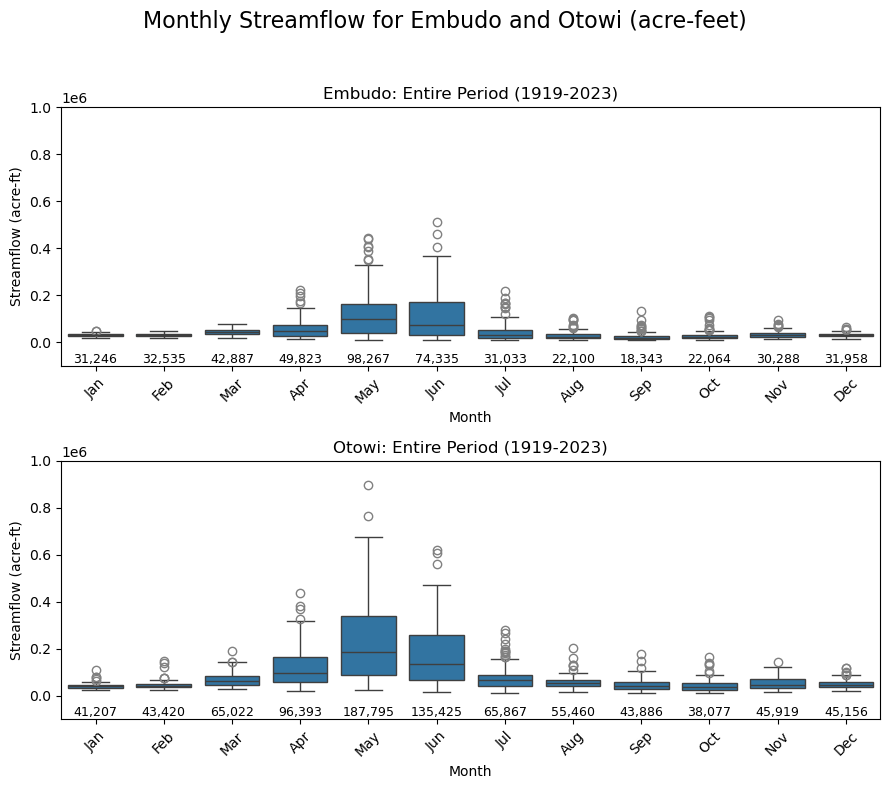

Plot saved as boxplot_Embudo_Otowi_1919_2023.png


In [24]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Define periods for analysis
periods = {
    'Entire Period (1919-2023)': (1919, 2023)
}

# Define months for labeling (all months from January to December)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Function to plot boxplots for a given stream and save as a file
def plot_and_save_boxplots(data, periods, filename):
    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, axes = plt.subplots(2, 1, figsize=(9, 8))
    fig.suptitle('Monthly Streamflow for Embudo and Otowi (acre-feet)', fontsize=16)

    # Ensure axes is iterable even if there's only one subplot
    if len(axes) == 1:
        axes = [axes]

    # Set common y-axis limits
    y_min = -100000
    y_max = 1000000

    # Loop through the periods
    for i, (period_name, (start_year, end_year)) in enumerate(periods.items()):
        # Filter data for the specific period and months
        period_data = data[(data['Year'] >= start_year) & (data['Year'] <= end_year)]

        # Plot Embudo data in the upper subplot (index 0)
        sns.boxplot(x='Month', y='Embudo_AF_month', data=period_data, ax=axes[0],
                    flierprops=dict(marker='o', markerfacecolor='none', markersize=6, linestyle='none', markeredgecolor='grey'))
        axes[0].set_title(f'Embudo: {period_name}')
        axes[0].set_xticks(range(12))  # Set tick positions for all months
        axes[0].set_xticklabels(months, rotation=45)  # Set month labels
        axes[0].set_ylabel('Streamflow (acre-ft)')
        axes[0].set_ylim(y_min, y_max)  # Set y-axis to the specified limits

        # Plot Otowi data in the lower subplot (index 1)
        sns.boxplot(x='Month', y='Otowi_AF_month', data=period_data, ax=axes[1],
                    flierprops=dict(marker='o', markerfacecolor='none', markersize=6, linestyle='none', markeredgecolor='grey'))
        axes[1].set_title(f'Otowi: {period_name}')
        axes[1].set_xticks(range(12))  # Set tick positions for all months
        axes[1].set_xticklabels(months, rotation=45)  # Set month labels
        axes[1].set_ylabel('Streamflow (acre-ft)')
        axes[1].set_ylim(y_min, y_max)  # Set y-axis to the specified limits

        # Annotate median values for Embudo (upper subplot)
        medians_embudo = period_data.groupby('Month')['Embudo_AF_month'].median()
        for j, median in enumerate(medians_embudo):
            axes[0].annotate(f'{median:,.0f}', xy=(j, -100000), ha='center', va='bottom', fontsize=9, color='black')

        # Annotate median values for Otowi (lower subplot)
        medians_otowi = period_data.groupby('Month')['Otowi_AF_month'].median()
        for j, median in enumerate(medians_otowi):
            axes[1].annotate(f'{median:,.0f}', xy=(j, -100000), ha='center', va='bottom', fontsize=9, color='black')


    # Adjust layout to prevent overlap and add a title
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Plot saved as {filename}")

# Assuming df7 contains the data
plot_and_save_boxplots(df7, periods, 'boxplot_Embudo_Otowi_1919_2023.png')

## Step 6. Aggregate Total Monthly Streamflow (acre-ft) to Total Annual Streamflow (acre-ft)

Create a copy of the DataFrame to work with.

In [25]:
# Create a copy to work with
# Also allows use of existing code from another project without having to change the DataFrame name
df8 = df7.copy()

In [26]:
df8.head()

,Otowi_AF_month,Embudo_AF_month,Year,Month,YM,ratio_AF_month
datetimeUTC,,,,,,
1919-01-31 00:00:00+00:00,35736.20,26439.67,1919,1,1919-01,1.351613
1919-02-28 00:00:00+00:00,33621.82,23702.48,1919,2,1919-02,1.418494
1919-03-31 00:00:00+00:00,86225.45,46087.93,1919,3,1919-03,1.870890
1919-04-30 00:00:00+00:00,314935.54,167702.48,1919,4,1919-04,1.877942
1919-05-31 00:00:00+00:00,569871.07,349745.45,1919,5,1919-05,1.629388


#### Check what DataFrames are Currently in Memory

- The `%who` DataFrame command is a Jupyter magic command that lists all DataFrame objects currently in memory in your current Jupyter notebook session. 
- Quickly seeing what DataFrame objects you have available to work with helps avoid confusion and potential naming conflicts—especially in long complex notebooks.

In [27]:
%who DataFrame

df	 df2	 df3	 df4	 df5	 df6	 df7	 df8	 df_embudo	 
df_otowi	 


#### What if you wanted to delete a DataFrame object from memory?

Perhaps you’re iterating through code edits, and you want to make sure the incorrect DataFrame is deleted?  Here’s how to clear the memory of DataFrame objects:

1.	Use the del keyword to delete specific DataFrames.<br>

2.	Use the gc.collect() function to run the garbage collector and release memory.  The gc.collect() function doesn’t delete everything from memory, only objects no longer referenced by the program.<br>


3.	If you want to reuse the same variable names later in your code as new DataFrames, then it’s a good idea to reset them to empty DataFrames to avoid potential errors or confusion about what data is stored in those variables.

```
# 1. delete specific dataframes
del df1, df2, df3

# 2. run garbage collector to release memory
import gc
gc.collect()

# 3. set variable names to empty DataFrame objects
df1 = pd.DataFrame() 
df2 = pd.DataFrame()
df3 = pd.DataFrame()
```

Now, back to aggregating monthly values in our DataFrame...

#### Calculate Total Annual Streamflow by Aggregating Monthly Values

- **Annual Totals**: Sum monthly totals (acre-ft/mo) for a given year to get a total annual acre-ft of streamflow.

- **For Historical Supply Studies**, you may also want to calculate an irrigation season streamflow total by specifying to only sum, for example, from April (month 4) to October (month 10).

New DataFrames with Annual Totals and Irrigation Season totals by year are created.

In [28]:
# Aggregate Total Monthly Streamflow (acre-ft) to Total Annual Streamflow (acre-ft)

# Assuming df8 is the DataFrame with the necessary data

# Filter the DataFrame for complete years: 1919 to 2023
df8_filtered = df8[(df8['Year'] >= 1919) & (df8['Year'] <= 2023)].copy()

# Group by 'Year' and calculate the sum of the relevant columns for all months of the year
df8_Year = df8_filtered.groupby('Year').agg({
    'Otowi_AF_month': 'sum',
    'Embudo_AF_month': 'sum'
})

# Group by 'Year' and calculate the sum of the relevant columns for the irrigation season (April, 4 to October, 10)
df8_IRR_season = df8_filtered[df8_filtered.index.month.isin([4, 5, 6, 7, 8, 9, 10])].groupby('Year').agg({
    'Otowi_AF_month': 'sum',
    'Embudo_AF_month': 'sum'
})

# Rename the columns to reflect the annual and irrigation season totals correctly
df8_Year = df8_Year.rename(columns={
    'Otowi_AF_month': 'Otowi_Year_AF',
    'Embudo_AF_month': 'Embudo_Year_AF'
})

df8_IRR_season = df8_IRR_season.rename(columns={
    'Otowi_AF_month': 'Otowi_IRR_AF',
    'Embudo_AF_month': 'Embudo_IRR_AF'
})

# Some double-checking
# Calculate ratio of the two, as a double-check to see how different streamflow is at the two gages
df8_Year['ratio_Year_AF'] = df8_Year['Otowi_Year_AF'] / df8_Year['Embudo_Year_AF']

# Some double-checking
# Calculate ratio of the two, as a double-check to see how different streamflow is at the two gages
df8_IRR_season['ratio_IRR_AF'] = df8_IRR_season['Otowi_IRR_AF'] / df8_IRR_season['Embudo_IRR_AF']

# Display the new dataframes
print("Annual Totals:")
print(df8_Year.head())
print(df8_Year.tail())

print("\nIrrigation Season Totals:")
print(df8_IRR_season.head())
print(df8_IRR_season.tail())

Annual Totals:
      Otowi_Year_AF  Embudo_Year_AF  ratio_Year_AF
Year                                              
1919     1659240.99      1018454.86       1.629175
1920     2158851.56      1430828.42       1.508812
1921     1581129.91      1171789.09       1.349330
1922     1227215.22       858134.88       1.430096
1923     1437318.35       931021.49       1.543808
      Otowi_Year_AF  Embudo_Year_AF  ratio_Year_AF
Year                                              
2019     1414764.29       842451.57       1.679342
2020      527012.24       274335.87       1.921048
2021      552589.10       323787.76       1.706640
2022      629773.88       378694.21       1.663014
2023     1252472.72       691959.67       1.810037

Irrigation Season Totals:
      Otowi_IRR_AF  Embudo_IRR_AF  ratio_IRR_AF
Year                                           
1919    1395905.46      837250.90      1.667249
1920    1835926.61     1221127.93      1.503468
1921    1280392.06      946078.01      1.353368
1922

Now save CSVs of total annual and irrigation season streamflow.

In [29]:
# Save the DataFrames as CSV files
df8_Year.to_csv('Streamflow_Annual_Total_1919_2023.csv', index=False)
df8_IRR_season.to_csv('Streamflow_IRR_Season_Total_1919_2023.csv', index=False)

#### Reset the index for year

The DataFrames for total annual and irrigation season streamflow need to have their index set to year to create proper time series.

**Explanation of Steps:**
1. **Reset Index:** `reset_index(inplace=True)` is used to turn the index back into a regular column.
2. **Rename Columns:** The `Year` column is renamed to `Year_index` to make it clear that it's the previous index.
3. **Create a New 'Year' Column:** The `Year_index` column is converted to `int3` type and stored in a new `Year` column.
4. **Set `Year_index` as Index:** The column `Year_index` is set as the new index.
5. **Drop Redundant Columns:** Any redundant columns (like `index`) that might appear after resetting the index are dropped.


This code will handle both df8_IRR_season and df8_Year in the same way.

In [30]:
# Reset the index for year

# Assuming df8_IRR_season and df8_Year are already defined

# Reset the index for df8_IRR_season
df8_IRR_season.reset_index(inplace=True)

# Rename the 'Year' column to 'Year_index' in df8_IRR_season
df8_IRR_season.rename(columns={'Year': 'Year_index'}, inplace=True)

# Create a new 'Year' column from 'Year_index' with int32 format
df8_IRR_season['Year'] = df8_IRR_season['Year_index'].astype('int32')

# Set 'Year_index' as the index
df8_IRR_season.set_index('Year_index', inplace=True)

# Drop the redundant 'index' column if it exists
if 'index' in df8_IRR_season.columns:
    df8_IRR_season.drop(columns=['index'], inplace=True)

# Reset the index for df8_Year
df8_Year.reset_index(inplace=True)

# Rename the 'Year' column to 'Year_index' in df8_Year
df8_Year.rename(columns={'Year': 'Year_index'}, inplace=True)

# Create a new 'Year' column from 'Year_index' with int32 format
df8_Year['Year'] = df8_Year['Year_index'].astype('int32')

# Set 'Year_index' as the index
df8_Year.set_index('Year_index', inplace=True)

# Drop the redundant 'index' column if it exists
if 'index' in df8_Year.columns:
    df8_Year.drop(columns=['index'], inplace=True)

# Display the resulting dataframes
print("Irrigation Season Totals:")
print(df8_IRR_season.head())

print("\nAnnual Totals:")
print(df8_Year.head())

Irrigation Season Totals:
            Otowi_IRR_AF  Embudo_IRR_AF  ratio_IRR_AF  Year
Year_index                                                 
1919          1395905.46      837250.90      1.667249  1919
1920          1835926.61     1221127.93      1.503468  1920
1921          1280392.06      946078.01      1.353368  1921
1922           974405.95      676310.09      1.440768  1922
1923          1121557.69      708616.86      1.582742  1923

Annual Totals:
            Otowi_Year_AF  Embudo_Year_AF  ratio_Year_AF  Year
Year_index                                                    
1919           1659240.99      1018454.86       1.629175  1919
1920           2158851.56      1430828.42       1.508812  1920
1921           1581129.91      1171789.09       1.349330  1921
1922           1227215.22       858134.88       1.430096  1922
1923           1437318.35       931021.49       1.543808  1923


#### Check the data types of the new DataFrames

In [31]:
# get the data types of each column
print("\nIrrigation Season: Data types of each column :")
print(df8_IRR_season.dtypes)

print("\nAnnual: Data types of each column :")
print(df8_Year.dtypes)


Irrigation Season: Data types of each column :
Otowi_IRR_AF     float64
Embudo_IRR_AF    float64
ratio_IRR_AF     float64
Year               int32
dtype: object

Annual: Data types of each column :
Otowi_Year_AF     float64
Embudo_Year_AF    float64
ratio_Year_AF     float64
Year                int32
dtype: object


In [32]:
# Save the DataFrames as CSV files
df8_Year.to_csv('Streamflow_Annual_Total_1919_2023_reset_index.csv', index=False)
df8_IRR_season.to_csv('Streamflow_IRR_Season_Total_1919_2023_reset_index.csv', index=False)

#### Boxplots to Visualize Annual Data

**Why Boxplots?**

Box plots help visualize annual streamflow distributions and show key statistics:

- Median: The middle value of the data.
- Quartiles: Values that divide the data into four equal parts.
- Outliers: Data points that fall significantly outside the overall trend.
- Interquartile Range (IQR): The range between the 25th and 75th percentiles, representing the middle 50% of the data.

In addition, box plots can help understand:
- Data spread and central tendency.
- Identification of unusual flow years, such as really high-flow or really low-flow years (outliers).
- Long-term trends in streamflow patterns. For example, if you create boxplots for different time periods, such as 1900-1950, 1951-2000, post-2000--or before and after a statistically significant change point in streamflow.  For example, portions of the Upper Colorado Basin which are adjacent to Rio Grande headwaters exhibit post-2000 streamflow declines associated with warmer and drier conditions (the “Millennial Drought”). For more information, see Hogan and Lundquist (2024), [Recent Upper Colorado River Streamflow Declines Driven by Loss of Spring Precipitation](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2024GL109826).

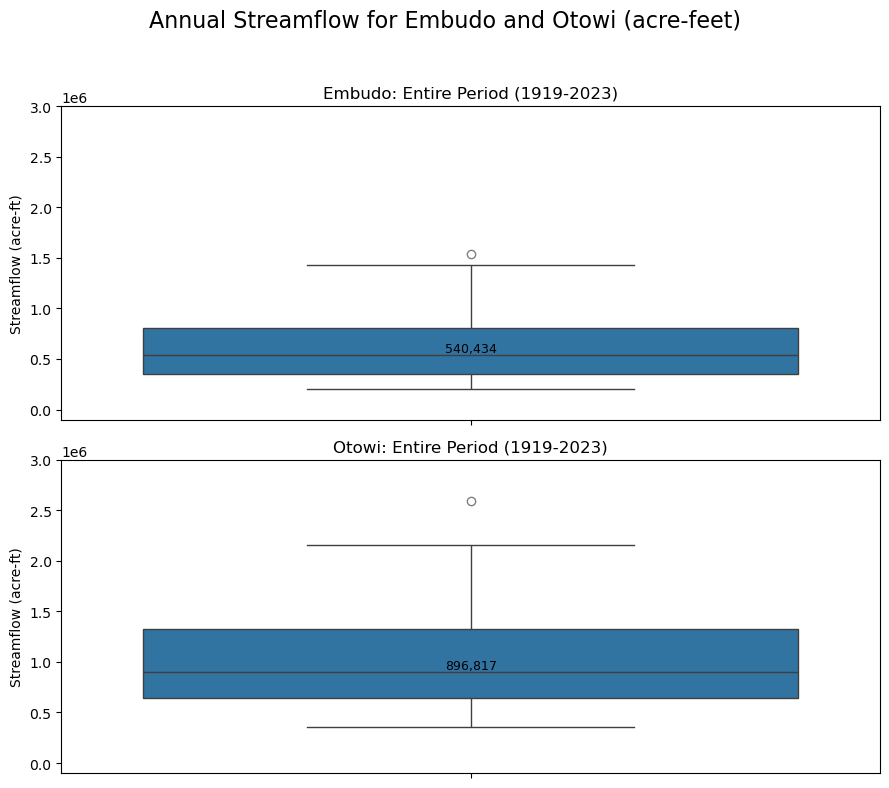

Plot saved as boxplot_Embudo_Otowi_Annual_1919_2023.png


In [33]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Define periods for analysis
periods = {
    'Entire Period (1919-2023)': (1919, 2023)
}

# Function to plot boxplots for a given stream and save as a file
def plot_and_save_boxplots(data, periods, filename):
    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, axes = plt.subplots(2, 1, figsize=(9, 8))
    fig.suptitle('Annual Streamflow for Embudo and Otowi (acre-feet)', fontsize=16)

    # Ensure axes is iterable even if there's only one subplot
    if len(axes) == 1:
        axes = [axes]

    # Set common y-axis limits
    y_min = -100000
    y_max = 3000000

    # Loop through the periods
    for i, (period_name, (start_year, end_year)) in enumerate(periods.items()):
        # Filter data for the specific period
        period_data = data[(data['Year'] >= start_year) & (data['Year'] <= end_year)]

        # Plot Embudo data in the upper subplot (index 0)
        sns.boxplot(y='Embudo_Year_AF', data=period_data, ax=axes[0],
                    flierprops=dict(marker='o', markerfacecolor='none', markersize=6, linestyle='none', markeredgecolor='grey'))
        axes[0].set_title(f'Embudo: {period_name}')
        axes[0].set_ylabel('Streamflow (acre-ft)')
        axes[0].set_ylim(y_min, y_max)  # Set y-axis to the specified limits

        # Plot Otowi data in the lower subplot (index 1)
        sns.boxplot(y='Otowi_Year_AF', data=period_data, ax=axes[1],
                    flierprops=dict(marker='o', markerfacecolor='none', markersize=6, linestyle='none', markeredgecolor='grey'))
        axes[1].set_title(f'Otowi: {period_name}')
        axes[1].set_ylabel('Streamflow (acre-ft)')
        axes[1].set_ylim(y_min, y_max)  # Set y-axis to the specified limits

        # Annotate median values for Embudo (upper subplot)
        median_embudo = period_data['Embudo_Year_AF'].median()
        axes[0].annotate(f'{median_embudo:,.0f}', xy=(0, median_embudo), ha='center', va='bottom', fontsize=9, color='black')

        # Annotate median values for Otowi (lower subplot)
        median_otowi = period_data['Otowi_Year_AF'].median()
        axes[1].annotate(f'{median_otowi:,.0f}', xy=(0, median_otowi), ha='center', va='bottom', fontsize=9, color='black')

    # Adjust layout to prevent overlap and add a title
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Plot saved as {filename}")

# Assuming df8_Year contains the data
plot_and_save_boxplots(df8_Year, periods, 'boxplot_Embudo_Otowi_Annual_1919_2023.png')

## Step 7. Plot Annual Streamflow

#### Create a hydrograph of annual total streamflow for the Embudo and Otowi gages

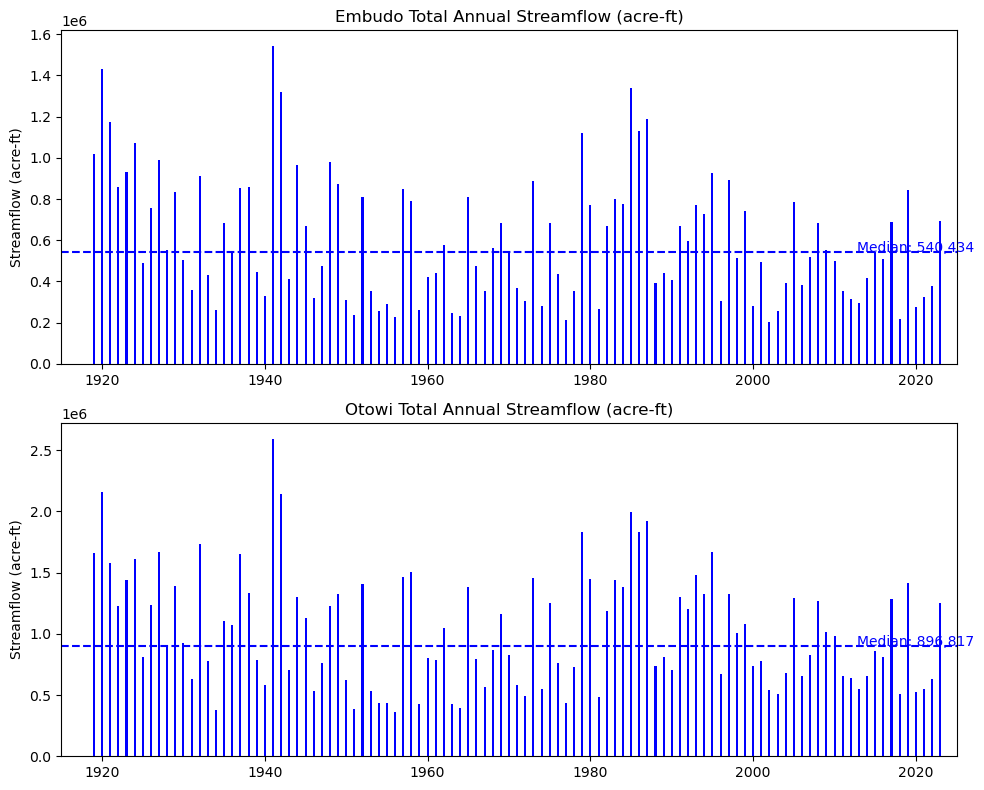

In [34]:
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec

# Calculate the median annual streamflow for Otowi and Embudo streamgages
median_otowi = df8_Year['Otowi_Year_AF'].median()
median_embudo = df8_Year['Embudo_Year_AF'].median()

# Create a figure for the second plot
fig2 = plt.figure(figsize=(10, 8), facecolor='white')  # Adjusted figure size
gs2 = gridspec.GridSpec(2, 1)  # Changed to 2 rows instead of 3

# Create subplots for the second plot
ax0 = fig2.add_subplot(gs2[0])  # Embudo Total Annual Streamflow
ax1 = fig2.add_subplot(gs2[1])  # Otowi Total Annual Streamflow

# Define a bar width
bar_width = 0.25

# Define the start and end of the x-axis using integer values for Year
x_start = 1915
x_end = 2025

# Plot for Embudo Total Annual Streamflow (now in ax0)
ax0.bar(df8_Year.index, df8_Year['Embudo_Year_AF'], width=bar_width, color='blue')
ax0.set_title('Embudo Total Annual Streamflow (acre-ft)')
ax0.set_ylabel('Streamflow (acre-ft)')
ax0.set_facecolor('white')
ax0.tick_params(axis='x', rotation=0)
ax0.set_xlim(x_start, x_end)
ax0.axhline(median_embudo, color='blue', linestyle='--', linewidth=1.5)  # Add median line
ax0.annotate(f'Median: {median_embudo:,.0f}', xy=(2020, median_embudo + 100), ha='center', color='blue')

# Plot for Otowi Total Annual Streamflow (now in ax1)
ax1.bar(df8_Year.index, df8_Year['Otowi_Year_AF'], width=bar_width, color='blue')
ax1.set_title('Otowi Total Annual Streamflow (acre-ft)')
ax1.set_ylabel('Streamflow (acre-ft)')
ax1.set_facecolor('white')
ax1.tick_params(axis='x', rotation=0)
ax1.set_xlim(x_start, x_end)
ax1.axhline(median_otowi, color='blue', linestyle='--', linewidth=1.5)  # Add median line
ax1.annotate(f'Median: {median_otowi:,.0f}', xy=(2020, median_otowi + 100), ha='center', color='blue')

# Adjust layout and remove extra space
plt.tight_layout()

# Save the figure
fig2.savefig('Plot_Bar_Total_Annual_Streamflow_Embudo_Otowi_with_Median.png', dpi=300)

# Show the plots
plt.show()